<a href="https://colab.research.google.com/github/namsalmaongoroeva/test1/blob/main/02_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задачи к Лекции 2

__Исходные данные__

Дан файл **"mlbootcamp5_train.csv"**. В нем содержатся данные об опросе 70000 пациентов с целью определения наличия заболеваний сердечно-сосудистой системы (ССЗ). Данные в файле промаркированы и если у человека имееются ССЗ, то значение **cardio** будет равно 1, в противном случае - 0. Описание и значения полей представлены во второй лекции.

__Загрузка файла__

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("/content/mlbootcamp5_train.csv",
                 sep=";",
                 index_col="id")
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Задачи

**1. Построить наивный байесовский классификатор для количественных полей age, height, weight, ap_hi, ap_lo. Исправить данные, если это необходимо. Привести матрицу неточностей и сравнить со значением полученным в ходе лекции. Попытаться объяснить разницу.**

Матрица неточностей (количественные):
[[9422 2015]
 [4616 6625]]


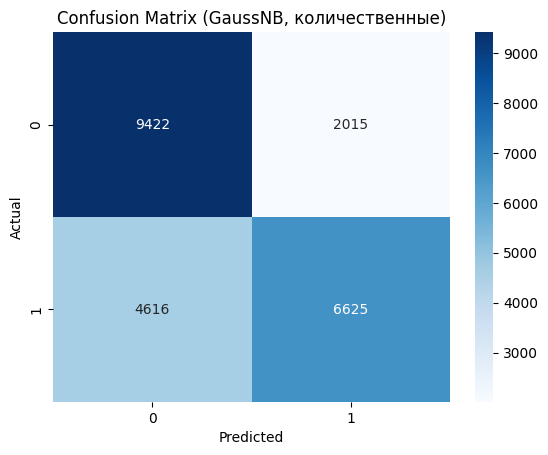

              precision    recall  f1-score   support

           0       0.67      0.82      0.74     11437
           1       0.77      0.59      0.67     11241

    accuracy                           0.71     22678
   macro avg       0.72      0.71      0.70     22678
weighted avg       0.72      0.71      0.70     22678



In [ ]:
# Приводим названия нужных столбцов
num_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# Быстрые проверки и коррекции
# Исправим выбросы по height, weight, ap_hi, ap_lo
df = df[(df['height'] > 100) & (df['height'] < 250)]
df = df[(df['weight'] > 30) & (df['weight'] < 300)]
df = df[(df['ap_hi'] > 60) & (df['ap_hi'] < 250)]
df = df[(df['ap_lo'] > 40) & (df['ap_lo'] < 200)]

# Преобразуем age в годы
df['age_years'] = (df['age'] / 365.25).astype(int)

# Подбираем количественные переменные для обучения
X = df[['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']]
y = df['cardio']

# Делим на train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Наивный байесовский классификатор
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# Матрица неточностей
cm = confusion_matrix(y_test, y_pred)
print("Матрица неточностей (количественные):")
print(cm)

# Визуализация
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (GaussNB, количественные)')
plt.show()

print(classification_report(y_test, y_pred))

**Комментарии:**



**2. Написать свой наивный байесовский классификатор для категориальных полей cholesterol, gluc. Привести матрицу неточностей и сравнить со значениями из задачи 1 (нельзя использовать готовое решение из sklearn) (не обязательно)**

Матрица неточностей (категориальные):
[[9001 2436]
 [6812 4429]]


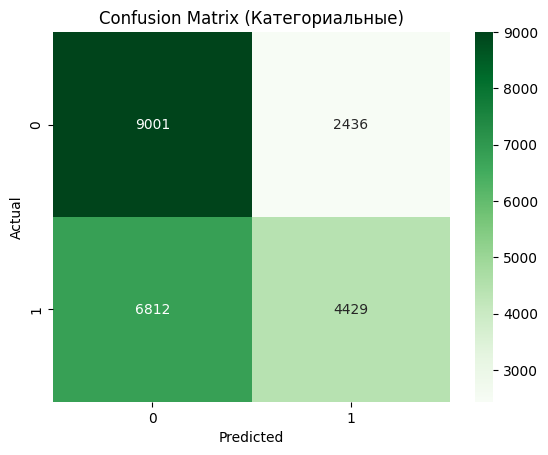

              precision    recall  f1-score   support

           0       0.57      0.79      0.66     11437
           1       0.65      0.39      0.49     11241

    accuracy                           0.59     22678
   macro avg       0.61      0.59      0.57     22678
weighted avg       0.61      0.59      0.58     22678



In [ ]:
# Your code here
cat_features = ['cholesterol', 'gluc']
X_cat = df[cat_features]
y_cat = df['cardio']

# Условные вероятности вручную
prob = {}
for feature in cat_features:
    prob[feature] = (
        X_cat.groupby([feature, y_cat]).size() / y_cat.value_counts()
    ).unstack().fillna(0)

# Байесовский классификатор для категориальных полей
def naive_bayes_predict_cat(X_input):
    p0 = (y_cat==0).mean()
    p1 = (y_cat==1).mean()
    y_pred = []
    for ix, row in X_input.iterrows():
        # Логарифмы вероятностей
        logprob0 = np.log(p0)
        logprob1 = np.log(p1)
        for f in cat_features:
            val = row[f]
            p_f0 = ((y_cat[(y_cat==0) & (X_cat[f]==val)].count())+1)/((y_cat==0).sum()+len(df[f].unique()))
            p_f1 = ((y_cat[(y_cat==1) & (X_cat[f]==val)].count())+1)/((y_cat==1).sum()+len(df[f].unique()))
            logprob0 += np.log(p_f0)
            logprob1 += np.log(p_f1)
        y_pred.append(1 if logprob1 > logprob0 else 0)
    return np.array(y_pred)

# Пусть тестовая выборка будет та же, что и выше
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y_cat, test_size=0.33, random_state=42)
y_cat_pred = naive_bayes_predict_cat(X_cat_test)

# Матрица неточностей
cm_cat = confusion_matrix(y_cat_test, y_cat_pred)
print("Матрица неточностей (категориальные):")
print(cm_cat)

sns.heatmap(cm_cat, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Категориальные)')
plt.show()

print(classification_report(y_cat_test, y_cat_pred))

**Комментарии:**


**3. Построить наивный байесовский классификатор для бинарных полей gender, smoke, alco, active. Привести матрицу неточностей и сравнить с предыдущими значениями.**

Матрица неточностей (бинарные):
[[9415 2022]
 [8914 2327]]


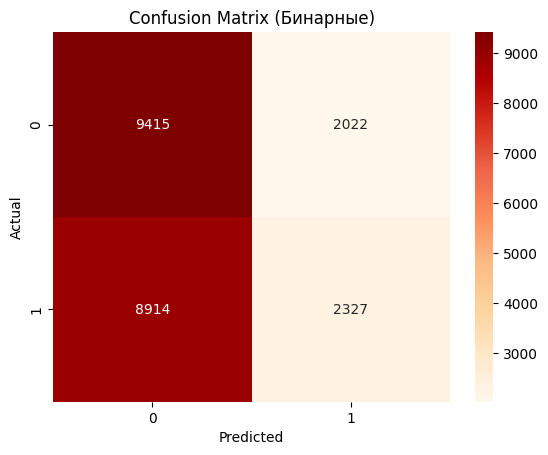

              precision    recall  f1-score   support

           0       0.51      0.82      0.63     11437
           1       0.54      0.21      0.30     11241

    accuracy                           0.52     22678
   macro avg       0.52      0.52      0.47     22678
weighted avg       0.52      0.52      0.47     22678



In [ ]:
# Your code here
bin_features = ['gender', 'smoke', 'alco', 'active']
X_bin = df[bin_features]
y_bin = df['cardio']

# Используем BernoulliNB
from sklearn.naive_bayes import BernoulliNB
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y_bin, test_size=0.33, random_state=42)

bnb = BernoulliNB()
bnb.fit(X_bin_train, y_bin_train)
y_bin_pred = bnb.predict(X_bin_test)

cm_bin = confusion_matrix(y_bin_test, y_bin_pred)
print("Матрица неточностей (бинарные):")
print(cm_bin)

sns.heatmap(cm_bin, annot=True, fmt='d', cmap='OrRd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Бинарные)')
plt.show()

print(classification_report(y_bin_test, y_bin_pred))

**Комментарии:**

**4. К этому моменту у вас есть три независимых классификатора: по количественным полям, категориальным и бинарным. Придумать, как их объединить в один единый классификатор, который учитывает все эти поля. Привести матрицу неточностей для него и сравнить с предыдущими значениями. Попытаться объяснить разницу.**

Матрица неточностей (общая):
[[9210 2227]
 [4786 6455]]


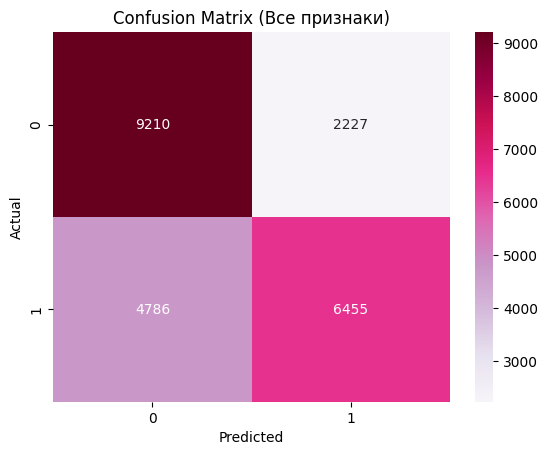

              precision    recall  f1-score   support

           0       0.66      0.81      0.72     11437
           1       0.74      0.57      0.65     11241

    accuracy                           0.69     22678
   macro avg       0.70      0.69      0.69     22678
weighted avg       0.70      0.69      0.69     22678



In [ ]:
# A lot of code here
# Объелиняем все отобранные признаки
X_all = pd.concat([
    X[['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']],
    df[cat_features],
    df[bin_features]
], axis=1)

# Перекодируем категориальные признаки
X_all = pd.get_dummies(X_all, columns=cat_features, drop_first=True)

X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y, test_size=0.33, random_state=42)

# Используем GaussianNB,
nb_all = GaussianNB()
nb_all.fit(X_all_train, y_all_train)
y_all_pred = nb_all.predict(X_all_test)

cm_all = confusion_matrix(y_all_test, y_all_pred)
print("Матрица неточностей (общая):")
print(cm_all)

sns.heatmap(cm_all, annot=True, fmt='d', cmap='PuRd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Все признаки)')
plt.show()

print(classification_report(y_all_test, y_all_pred))

**Комментарии:** Ваши комментарии здесь.

**5. (Не обязательно) Теперь мы умеем делать классификацию в рамках наивного предположения об независимости всех признаков. Сейчас же нужно попробовать учесть взаимосвязь между признаками через условные вероятности. Построить классификатор с учетом такой связи. Сравнить результат с ранее полученными значениями.**

**Комментарии:** Ваши комментарии здесь.